In [17]:
from lightlab.equipment.visa_bases import VISAInstrumentDriver
from lightlab.laboratory.instruments import Instrument
import numpy as np
import time
from lightlab.equipment.lab_instruments import Keithley_2400_SM
from lightlab.equipment.lab_instruments import Tektronix_TDS6154C_Oscope
import pyvisa
from lightlab.util.data import Waveform
from lightlab.util.sweep import NdSweeper

In [18]:
#Pulser driver
from lightlab.equipment.visa_bases import VISAInstrumentDriver
from lightlab.laboratory.instruments import Instrument
class Avtech_7B_B_Driver(VISAInstrumentDriver):
    '''An Avtech-7B-B pulser driver - will work with most -B Avtech generators.
        Manual: https://www.avtechpulse.com/manuals/programming/programming.pdf
    '''
    instrument_category = Instrument
    
    def __init__(self, name=None, address=None):
        VISAInstrumentDriver.__init__(self, name=name, address=address)
    # Sets conditions to what they are when the pulser is turned on.
    def startup(self):
        self.write('*RST') 
    # Set pulse width
    def set_PW(self, pw):
        self.write('pulse:width {:s}'.format(pw))
    #S MS US NS PS - must write pulse width as e.g. 100ns 100us etc.
    # Set pulse delay
    def set_PD(self, pd):
        self.write('pulse:delay {:s}'.format(pd))
    #S MS US NS PS - must write pulse width as e.g. 100ns 100us etc.               
    def set_freq(self, freq):
        self.write('source:frequency {:s}'.format(freq))
    #MHZ KHZ HZ UHZ - write freq as 1 KHz, default unit is hertz so 1000 = 1000 Hz, scientific notation works
    def query_pw(self, limit):
        self.write('pulse:width? {:s}'.format(limit) )              
    def set_volt(self,volt):
        self.write('volt {:s}'.format(volt))
    def turn_on(self):
        self.write('output on')
    def turn_off(self):
        self.write('output off')    

In [19]:
#Tektronix driver
class Tektronix_TDS3054B(VISAInstrumentDriver):
    '''http://ece-research.unm.edu/jimp/650/instr_docs/tds3000_prog.pdf
    '''
    instrument_category = Instrument
    totalChans = 4
    isSampling = None
    _runModeParam = 1
    _runModeSingleShot = None
   
    
    def __init__(self, name=None, address=None):
        VISAInstrumentDriver.__init__(self, name=name, address=address)
       # Turns output off and sets output level to zero.
    def startup(self):
        self.write('*RST') 
    # Select measure function - by default CURR    
    def timeBaseConfig(self, avgCnt=None, duration=None):
        self.write('HORIZONTAL:MAIN:SAMPLERATE', 2.5e9)
        if avgCnt is not None and avgCnt > 1:
            self.write('ACQUIRE:NUMAVG', avgCnt)
        if duration is not None:
            self.write('HORIZONTAL:MAIN:SCALE', duration / 10)
            self.write('HORIZONTAL:RECORDLENGTH', 10 * int(duration * 2.5e9))
            self.setConfigParam('DATA:START', 1)
            self.setConfigParam('DATA:STOP', int(duration * 2.5e9))
            
    
    def _triggerAcquire(self, timeout=None):
        ''' Sends a signal to the scope to wait for a trigger event.
            Waits until acquisition completes or timeout (in seconds).

            If timeout is very long, it will try a test first
        '''
        if timeout is None:
            timeout = self.timeout / 1e3
        if timeout > 60:
            logger.warning(f'Long timeout {timeout} specified, testing')
            old_avgCnt = self.timebaseConfig()['avgCnt']
            self.timebaseConfig(avgCnt=2)
            self._triggerAcquire(timeout=10)
            logger.warning('Test succeeded. Doing long average now')
            self.timebaseConfig(avgCnt=old_avgCnt)
        self.write('ACQUIRE:STATE 1')  # activate the trigger listener
        # Bus and entire program stall until acquisition completes. Maximum of 30 seconds
        self.wait(int(timeout * 1e3))

    def __transferData(self, chan):
        ''' Returns the raw data pulled from the scope as time (seconds) and voltage (Volts)
            Args:
                chan (int): one channel at a time

            Returns:
                :mod:`data.Waveform`: a time, voltage paired signal

            Todo:
                Make this binary transfer to go even faster
        '''
        chStr = 'CH' + str(chan)
        self.write('DATA:ENCDG ASCII')
        self.write('DATA:SOURCE '+chStr)

        voltRaw = self.query_ascii_values('CURV?')
        return voltRaw

    
    
    def __getUnit(self):
        ''' Gets the unit of the waveform as a string.

            Normally, this will be '"V"', which can be converted to 'V'
        '''

        yunit_query = self.query('WFMPRE:YUNIT?')
        return yunit_query.replace('"', '')


    
    def __scaleData(self, voltRaw):
        ''' Scale to second and voltage units.

            DSA and DPO are very annoying about treating ymult and yscale differently.
            TDS uses ymult not yscale

            Args:
                voltRaw (ndarray): what is returned from ``__transferData``

            Returns:
                (ndarray): time in seconds, centered at t=0 regardless of timebase position
                (ndarray): voltage in volts

            Notes:
                The formula for real voltage should be (Y - YOFF) * YSCALE + YZERO.
                The Y represents the position of the sampled point on-screen,
                YZERO, the reference voltage, YOFF, the offset position, and
                YSCALE, the conversion factor between position and voltage.
        '''
        #get = lambda param: float(self.getConfigParam('WFMOUTPRE:' + param, forceHardware=True))
        

        voltage = (np.array(voltRaw) - float(self.query('WFMPRE:YOFF?'))) \
            * float(self.query('WFMPRE:YMULT?')) \
            + float(self.query('WFMPRE:YZERO?'))
    
    
        sample_rate = 1/float(self.query('WFMPre:XINcr?'))
        # time = np.linspace(-1, 1, len(voltage)) / 2 * timeDivision * 10
        time = np.arange(len(voltage)) / sample_rate
        time -= np.mean(time)

        return time, voltage

    
    def run(self, continuousRun=True):
        ''' Sets the scope to continuous run mode, so you can look at it in lab,
            or to single-shot mode, so that data can be acquired

            Args:
                continuousRun (bool)
        '''
    
        
        if continuousRun:
            self.write(self._runModeParam,'RUNSTOP')
            
        else:
            self._runModeSingleShot
            
        if continuousRun:
            self.write('ACQUIRE:STATE', 1)
    
    
    def _setupSingleShot(self, isSampling):
        ''' Set up a single shot acquisition.

                Not running continuous, and
                acquire mode set SAMPLE/AVERAGE

            Subclasses usually have additional settings to set here.

            Args:
                isSampling (bool): is it in sampling (True) or averaging (False) mode
                forcing (bool): if False, trusts that no manual changes were made, except to run continuous/RUNSTOP

            Todo:
                Missing DPO trigger source setting.
                Should we force it when averaging?
                Probably not because it could be CH1, CH2, AUX.
        '''
        self.run(False)
        
        if isSampling:
            self.write('ACQUIRE:MODE SAMPLE')
        else: self.write('ACQUIRE:MODE AVERAGE')
                          
            
    def acquire(self, chans=None, avgCnt=0, duration=0, timeout = None):

        for c in chans:
            if c > self.totalChans:
                raise Exception('Received channel: ' + str(c) +
                                '. Max channels of this scope is ' + str(self.totalChans))

        # Channel select
        for ich in range(1, 1 + self.totalChans):
            thisState = 1 if ich in chans else 0
            self.write('SELECT:CH' + str(ich))

            
            
        isSampling = 0
        #isSampling = 1
        self._setupSingleShot(isSampling)    
        self._triggerAcquire(timeout=timeout)  
        
        wfms = [None] * len(chans)
        for i, c in enumerate(chans):
            vRaw = self.__transferData(c)
            t, v = self.__scaleData(vRaw)
            unit = self.__getUnit()
            wfms[i] = Waveform(t, v, unit=unit)

        return wfms           
                   
        
The following instructs every 3rd data point (SP = 3) starting at address 200 for transfer:
CMD$="WFSU SP,3,FP,200": CALL IBWRT(SCOPE%,CMD$)
    
    
    
FILE$="CHAN1.DAT":RD$=SPACE$(3)
CMD$="CHDR SHORT; C1:WF?"
CALL IBWRT(SCOPE%,CMD$)
CALL IBRD(SCOPE%,RD$) ' Skip first 3 characters "C1:" CALL IBRDF(SCOPE%,FILE$) ' Save data in file "CHAN1.DAT"



SyntaxError: invalid syntax (<ipython-input-19-f5d693732b6a>, line 186)

In [20]:
class LeCroy_Waverunner_Driver(VISAInstrumentDriver):
    '''LeCroy Waverunner 8404   
    http://cdn.teledynelecroy.com/files/manuals/maui-remote-control-and-automation-manual.pdf
    '''
    instrument_category = Instrument
    totalChans = 4
    isSampling = None
    _runModeParam = 1
    _runModeSingleShot = None

    
    def _setupSingleShot(self, isSampling):
        ''' Set up a single shot acquisition.

                Not running continuous, and
                acquire mode set SAMPLE/AVERAGE

            Subclasses usually have additional settings to set here.

            Args:
                isSampling (bool): is it in sampling (True) or averaging (False) mode
                forcing (bool): if False, trusts that no manual changes were made, except to run continuous/RUNSTOP

            Todo:
                Missing DPO trigger source setting.
                Should we force it when averaging?
                Probably not because it could be CH1, CH2, AUX.
        '''
        self.run(False)
        
        if isSampling:
            self.write('ACQUIRE:MODE SAMPLE')
        else: self.write('ACQUIRE:MODE AVERAGE')
            
            
    def __getUnit(self):
        ''' Gets the unit of the waveform as a string.

            Normally, this will be '"V"', which can be converted to 'V'
        '''

        #yunit_query = self.getConfigParam('WFMOUTPRE:YUNIT', forceHardware=True)
        VerticalUnits = self.getConfigParam('app.Acquisition.C1.Out.Result.VerticalUnits', forceHardware = True)
        return yunit_query.replace('"', '')

    def __transferData(self, chan):
        ''' Returns the raw data pulled from the scope as time (seconds) and voltage (Volts)
            Args:
                chan (int): one channel at a time

            Returns:
                :mod:`data.Waveform`: a time, voltage paired signal

            Todo:
                Make this binary transfer to go even faster
        '''
        chStr = 'CH' + str(chan)
        self.setConfigParam('DATA:ENCDG', 'ASCII')
        self.setConfigParam('DATA:SOURCE', chStr)
        self.open()
        try:
            voltRaw = self.mbSession.query_ascii_values('CURV?')
        except pyvisa.VisaIOError as err:
            logger.error('Problem during query_ascii_values(\'CURV?\')')
            try:
                self.close()
            except pyvisa.VisaIOError:
                logger.error('Failed to close! %s', self.address)
            raise err
        self.close()
        return voltRaw

    def acquire(self, chans=None, avgCnt=0, duration=0, timeout = None):

        for c in chans:
            if c > self.totalChans:
                raise Exception('Received channel: ' + str(c) +
                                '. Max channels of this scope is ' + str(self.totalChans))

# Don't need now that commands can start with C...)
#         # Channel select
#         for ich in range(1, 1 + self.totalChans):
#             thisState = 1 if ich in chans else 0
#             self.write('SELECT:CH' + str(ich))

            
            
        isSampling = 0
        #isSampling = 1
        self._setupSingleShot(isSampling)    
        self._triggerAcquire(timeout=timeout)  
        
        wfms = [None] * len(chans)
        for i, c in enumerate(chans):
            vRaw = self.__transferData(c)
            t, v = self.__scaleData(vRaw)
            unit = self.__getUnit()
            wfms[i] = Waveform(t, v, unit=unit)

        return wfms    


In [21]:
#START SCOPE
#scope = Tektronix_TDS3054B(name='My scope', address='prologix://lightwave-lab-prologix2.ee.princeton.edu/2')
lecroy =  LeCroy_Waverunner_Driver(name='LeCroy Scope', address='TCPIP0::128.112.48.124::inst0::INSTR')

print(lecroy.driver.instrID())
if lecroy.isLive(): 
    print('Connection is good for scope') 
    


2021-02-23 13:31:13,543 - INFO - lightlab:
	Found LeCroy Scope in TCPIP0::128.112.48.124::inst0::INSTR.


*IDN LECROY,WAVERUNNER8404,LCRY4204N20439,8.8.0
Connection is good for scope


In [22]:
#START PULSER
av = Avtech_7B_B_Driver(name='My Pulser', address='GPIB0::14::INSTR')
#av.driver.instrID()
if av.isLive():
    print('Connection is good for Avtech') 

2021-02-23 13:31:14,157 - INFO - lightlab:
	Found My Pulser in GPIB0::14::INSTR.


Connection is good for Avtech


In [29]:
# set pulser

av.driver.set_PW('30ns')
av.driver.set_freq('3Hz')
av.driver.set_volt('13')

av.driver.turn_on()

In [30]:
# stop pulser
av.driver.turn_off()

2020-10-14 17:13:24,551 - WARNING - lightlab.visa:
	Access to VISAObject.resMan will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,569 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,577 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,666 - WARNING - lightlab.visa:
	Access to VISAObject.resMan will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,677 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,686 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 


C1:INSP "
DESCRIPTOR_NAME    : WAVEDESC           
TEMPLATE_NAME      : LECROY_2_3         
COMM_TYPE          : byte               
COMM_ORDER         : LOFIRST            
WAVE_DESCRIPTOR    : 346                
USER_TEXT          : 0                  
RES_DESC1          : 0                  
TRIGTIME_ARRAY     : 0                  
RIS_TIME_ARRAY     : 0                  
RES_ARRAY1         : 0                  
WAVE_ARRAY_1       : 2002               
WAVE_ARRAY_2       : 0                  
RES_ARRAY2         : 0                  
RES_ARRAY3         : 0                  
INSTRUMENT_NAME    : LECROYWaveRunnerWO 
INSTRUMENT_NUMBER  : 20439              
TRACE_LABEL        :                    
RESERVED1          : 2002               
RESERVED2          : 0                  
WAVE_ARRAY_COUNT   : 2002               
PNTS_PER_SCREEN    : 2000               
FIRST_VALID_PNT    : 0                  
LAST_VALID_PNT     : 2001               
FIRST_POINT        : 0                  
SPARSI

2020-10-14 17:13:24,768 - WARNING - lightlab.visa:
	Access to VISAObject.resMan will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,780 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 
2020-10-14 17:13:24,788 - WARNING - lightlab.visa:
	Access to VISAObject.mbSession will be deprecated soon. Please include it in InstrumentSessionBase. 


C3:INSP "
DESCRIPTOR_NAME    : WAVEDESC           
TEMPLATE_NAME      : LECROY_2_3         
COMM_TYPE          : byte               
COMM_ORDER         : LOFIRST            
WAVE_DESCRIPTOR    : 346                
USER_TEXT          : 0                  
RES_DESC1          : 0                  
TRIGTIME_ARRAY     : 0                  
RIS_TIME_ARRAY     : 0                  
RES_ARRAY1         : 0                  
WAVE_ARRAY_1       : 2002               
WAVE_ARRAY_2       : 0                  
RES_ARRAY2         : 0                  
RES_ARRAY3         : 0                  
INSTRUMENT_NAME    : LECROYWaveRunnerWO 
INSTRUMENT_NUMBER  : 20439              
TRACE_LABEL        :                    
RESERVED1          : 2002               
RESERVED2          : 0                  
WAVE_ARRAY_COUNT   : 2002               
PNTS_PER_SCREEN    : 2000               
FIRST_VALID_PNT    : 0                  
LAST_VALID_PNT     : 2001               
FIRST_POINT        : 0                  
SPARSI

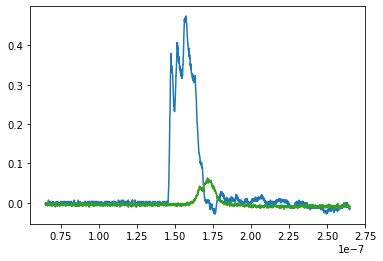

In [633]:
# test and save pulsing and stop
import matplotlib.pyplot as plt
import json

A2=4*10**(-5) # Device area in cm2
A3=4*10**(-4)
A4=0.002
A5=0.01
A6=0.1

A7=0.02*0.02 #200 um * 200 um laser, in cm2

A9=0.01*0.01 #100 um * 100 um laser, in cm2

A8=2*10**(-4)

A=A7


# R1=25
# R2=50


# R=R2


voltage = str(13)




# set pulser

# av.driver.set_PW('20ns')
# av.driver.set_freq('5Hz')
# av.driver.set_volt(voltage)
# av.driver.turn_on()



# time.sleep(0.1)


# channel 1


wd_1 =lecroy.driver.query("C1:INSP? 'WAVEDESC'")
print(wd_1) # This is good to check to make sure units are V and s and has a lot of useful info for debugging
#comment if annoying


vg_pos = wd_1.find('VERTICAL_GAIN')
v_gain_1 = float(wd_1[vg_pos+20:vg_pos+36])

vo_pos = wd_1.find('VERTICAL_OFFSET')
v_offset_1 = float(wd_1[vo_pos+20:vo_pos+40])

hi_pos = wd_1.find('HORIZ_INTERVAL')
h_int_1 = float(wd_1[hi_pos+20:hi_pos+32])

ho_pos = wd_1.find('HORIZ_OFFSET')
h_offset_1 = float(wd_1[ho_pos+20:ho_pos+38])

#CHECK THIS##########
sample_num_1= int((lecroy.driver.query(r"""vbs? 'return=app.Acquisition.C1.Out.Result.Samples' """))[4:])



def query_sara(self,queryStr):
    ret_bytes = None
    try:
        self.mbSession = self.resMan.open_resource(self.address)
        ret_bytes = self.mbSession.query_binary_values(queryStr, datatype = 'b')
        
    finally:
        self.mbSession.close()
        self.mbSession = None
                
    return ret_bytes
        
raw_volt_c1 = query_sara(lecroy.driver,"C1:WF? DAT1")

scaled_volt_c1 = []
for i in raw_volt_c1:
    scaled_volt_c1.append(i*v_gain_1-v_offset_1)

time_ax_1 = np.linspace(0,sample_num_1,sample_num_1)


time_ax_scaled_1 = []    
for i in time_ax_1:
    time_ax_scaled_1.append(i*h_int_1-h_offset_1)
     
plt.plot(time_ax_scaled_1,scaled_volt_c1)


time_ax_scaled_c1_arr = np.asarray(time_ax_scaled_1)
scaled_volt_c1_arr = np.asarray(scaled_volt_c1)

file = open('C:/lianfeng/20210223/try_Ch1_{0}.json'.format(voltage), 'a')
json.dump(scaled_volt_c1_arr.tolist(), file)
json.dump(time_ax_scaled_c1_arr.tolist(), file)
#####CHECK THIS ^^^^





# time.sleep(0.1)

#channel 3
chan = 3


wd_3 =lecroy.driver.query("C3:INSP? 'WAVEDESC'")
print(wd_3) # This is good to check to make sure units are V and s and has a lot of useful info for debugging
#comment if annoying

# Variables to scale the vertical and horizontal axes

vg_pos_3 = wd_3.find('VERTICAL_GAIN')
v_gain_3 = float(wd_3[vg_pos_3+20:vg_pos_3+36])

vo_pos_3 = wd_3.find('VERTICAL_OFFSET')
v_offset_3 = float(wd_3[vo_pos_3+20:vo_pos_3+40])

hi_pos_3 = wd_3.find('HORIZ_INTERVAL')
h_int_3 = float(wd_3[hi_pos_3+20:hi_pos_3+32])

ho_pos_3 = wd_3.find('HORIZ_OFFSET')
h_offset_3 = float(wd_3[ho_pos_3+20:ho_pos_3+38])


#CHECK THIS##########
sample_num_3 = int(lecroy.driver.query(r"""vbs? 'return=app.Acquisition.C3.Out.Result.Samples' """)[4:])



def query_sara(self,queryStr):
    ret_bytes = None
    try:
        self.mbSession = self.resMan.open_resource(self.address)
        ret_bytes = self.mbSession.query_binary_values(queryStr, datatype = 'b')
        
    finally:
        self.mbSession.close()
        self.mbSession = None
                
    return ret_bytes
        
raw_volt_c3 = query_sara(lecroy.driver,"C3:WF? DAT1")

scaled_volt_c3 = []
for i in raw_volt_c3:
    scaled_volt_c3.append(i*v_gain_3-v_offset_3)

time_ax_3 = np.linspace(0,sample_num_3,sample_num_3)


time_ax_scaled_3 = []    
for i in time_ax_3:
    time_ax_scaled_3.append(i*h_int_3-h_offset_3)
     
plt.plot(time_ax_scaled_3,scaled_volt_c3)


time_ax_scaled_c3_arr = np.asarray(time_ax_scaled_3)
scaled_volt_c3_arr = np.asarray(scaled_volt_c3)

file = open('C:/lianfeng/20210223/try_Ch3_{0}.json'.format(voltage), 'a')
json.dump(scaled_volt_c3_arr.tolist(), file)
json.dump(time_ax_scaled_c3_arr.tolist(), file)



# # # channel 2
# # chan = 2
# # avgCnt=5, duration=200e-6
# # a = scope.driver.acquire([chan], timeout=50)[0].getData()
# # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
# # b = np.asarray(a)

# # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
# # json.dump(b.tolist(), file)

# # time.sleep(0.1)

# trash save
# time.sleep(0.1)

#channel 3
chan = 3


wd_3 =lecroy.driver.query("C3:INSP? 'WAVEDESC'")
print(wd_3) # This is good to check to make sure units are V and s and has a lot of useful info for debugging
#comment if annoying

# Variables to scale the vertical and horizontal axes
vg_pos_3 = wd_3.find('VERTICAL_GAIN')
v_gain_3 = float(wd_3[vg_pos_3+20:vg_pos_3+36])

vo_pos_3 = wd_3.find('VERTICAL_OFFSET')
v_offset_3 = float(wd_3[vo_pos_3+20:vo_pos_3+40])

hi_pos_3 = wd_3.find('HORIZ_INTERVAL')
h_int_3 = float(wd_3[hi_pos_3+20:hi_pos_3+32])

ho_pos_3 = wd_3.find('HORIZ_OFFSET')
h_offset_3 = float(wd_3[ho_pos_3+20:ho_pos_3+38])


#CHECK THIS##########
sample_num_3 = int(lecroy.driver.query(r"""vbs? 'return=app.Acquisition.C3.Out.Result.Samples' """)[4:])



def query_sara(self,queryStr):
    ret_bytes = None
    try:
        self.mbSession = self.resMan.open_resource(self.address)
        ret_bytes = self.mbSession.query_binary_values(queryStr, datatype = 'b')
        
    finally:
        self.mbSession.close()
        self.mbSession = None
                
    return ret_bytes
        
raw_volt_c3 = query_sara(lecroy.driver,"C3:WF? DAT1")

scaled_volt_c3 = []
for i in raw_volt_c3:
    scaled_volt_c3.append(i*v_gain_3-v_offset_3)

time_ax_3 = np.linspace(0,sample_num_3,sample_num_3)


time_ax_scaled_3 = []    
for i in time_ax_3:
    time_ax_scaled_3.append(i*h_int_3-h_offset_3)
     
plt.plot(time_ax_scaled_3,scaled_volt_c3)


time_ax_scaled_c3_arr = np.asarray(time_ax_scaled_3)
scaled_volt_c3_arr = np.asarray(scaled_volt_c3)
file = open('C:/lianfeng/trash/trash.json', 'a')

json.dump(scaled_volt_c3_arr.tolist(), file)
json.dump(time_ax_scaled_c3_arr.tolist(), file)



# # time.sleep(0.1) 

# stop pulser
av.driver.turn_off()

# # with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190801/try_Ch1_{0}.json'.format(voltage)) as f:
# #     data_ch1 = json.load(f)

# # #with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch2_{0}_15ns.json'.format(voltage)) as f:
# # #    data_ch2 = json.load(f)    


# # with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch3_{0}_15ns.json'.format(voltage)) as f:
# #     data_ch3 = json.load(f)
    
# #     #length=10000

# # pick=3000 #put the pulse around the 3rd grid

# # V_chan1=sum(data_ch1[1][pick:(pick+50)])/51

# # V_chan2=sum(data_ch2[1][pick:(pick+50)])/51

# # V_chan3=sum(data_ch3[1][pick:(pick+50)])/51

# # CurrentDensity=(10*V_chan1-V_chan2)/(R*A)


# # print(10*V_chan1)
# # print(V_chan2)
# # print(V_chan3)
# # print(CurrentDensity)
    





In [83]:
ho_pos = wd_1.find('HORIZ_OFFSET')
h_offset_1 = float(wd_1[ho_pos+20:ho_pos+38])
h_offset_1

-8.80114585e-08

In [102]:
# stop pulser
av.driver.turn_off()

In [638]:
# DATA PROCESSING

import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


voltage = str(0)

    
#with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch1_{0}.json'.format(voltage)) as f:
#    data_ch1 = json.load(f)

with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch2_{0}_15ns.json'.format(voltage)) as f:
    data_ch2 = json.load(f)    


with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch3_{0}_15ns.json'.format(voltage)) as f:
    data_ch3 = json.load(f)

    
max(data_ch2[1])


2.72

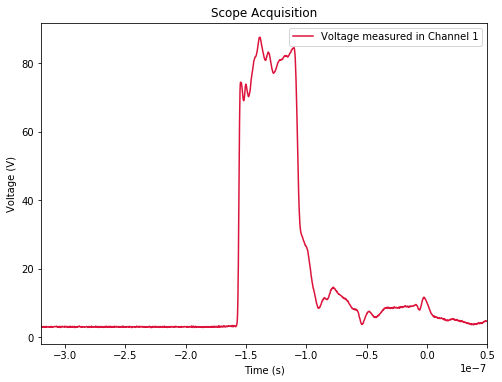

In [540]:
#CHANNEL 1 VOLTAGE
fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)

    
ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(-0.00000032, 0.00000005)

ax1.plot(data_ch1[0], [(10*i) for i in data_ch1[1]],color='crimson', label = 'Voltage measured in Channel 1')
#ax1.plot(data_ch1[0], data_ch1[1] , color='crimson', label = 'Channel 1')

#ax1.plot(data_ch1[0], data_ch1[1] , color='crimson', label = 'Channel 1')


plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/ch1_voltage_glass_120V_ns_NoLoad.png',  bbox_inches='tight', dpi =200) 


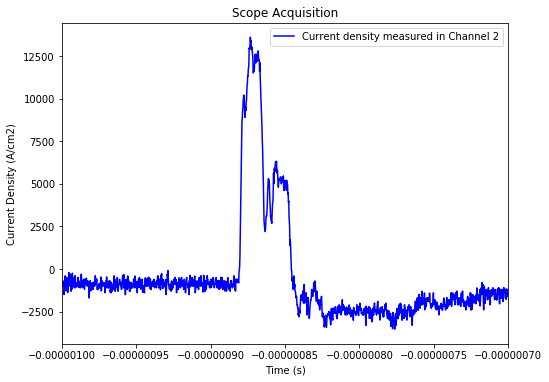

In [639]:
#CHANNEL 2 current density

A2=4*10**(-5) # Device area in cm2
A3=4*10**(-4)
A4=0.002
A5=0.01
A6=0.1

A7=0.02*0.02 #200 um * 200 um laser, in cm2

A8=2*10**(-4)

A=A8

fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Current Density (A/cm2)')
ax1.set_xlim(-0.000001, -0.0000007)
#ax1.plot(data_ch2[0], data_ch2[1] , color='crimson', label = 'Current density measured in Channel 2')
ax1.plot(data_ch2[0], [(i/A) for i in data_ch2[1]],color='blue', label = 'Current density measured in Channel 2')
plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/ch2_current density_200V_15ns.png',  bbox_inches='tight', dpi =200) 

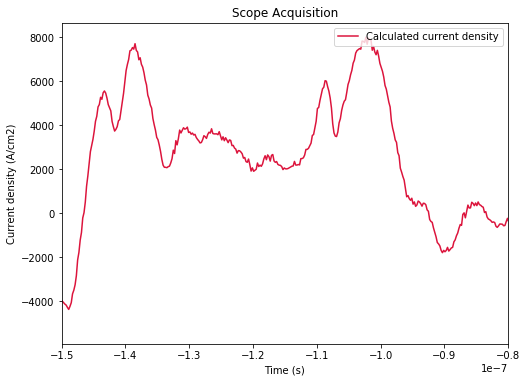

In [542]:
#CURRENT ON THE DEVICE

A2=4*10**(-5) # Device area in cm2
A3=4*10**(-4)
A4=0.002
A5=0.01
A6=0.1

A7=0.02*0.02 #200 um * 200 um laser, in cm2

A=A7


R1=814 #814 O
R2=177
R3=53.4
R4=10.4
R5=2.4

R=R4


fig1 = plt.figure(figsize=(8,13))
ax2 = fig1.add_subplot(211)



ax2.set_title("Scope Acquisition")    
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current density (A/cm2)')


ax2.set_xlim(-0.00000015, -0.00000008)
#ax2.set_ylim(0, 4000)
ax2.plot(data_ch1[0], [(10*i-j)/(A*R) for i, j in zip(data_ch1[1], data_ch2[1])], color='crimson', label = 'Calculated current density')


plt.legend(loc ='upper right')

plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/grating_current_sa_120V_ns_noLoad.png',  bbox_inches='tight', dpi =200)


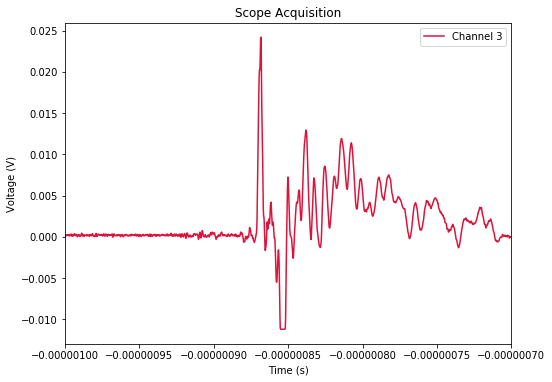

In [640]:
#Photovoltage - channel 3 - light emission intensity

fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(-0.000001, -0.0000007)
ax1.plot(data_ch3[0], data_ch3[1] , color='crimson', label = 'Channel 3')

plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/ch3_photovoltage_200V_15ns.png',  bbox_inches='tight', dpi =200) 


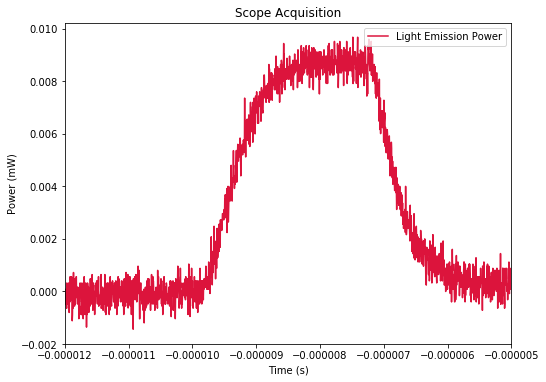

In [86]:
#Calculated power from channel 3 - light emission intensity

fig1 = plt.figure(figsize=(8,13))
ax1 = fig1.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Power (mW)')
ax1.set_xlim(-0.000012, -0.000005)
original = data_ch3[0]
#trim = original[0:9855]


Sensitivity=0.5 #A/W
Load=50

ax1.plot(original, [1000*i/(Sensitivity*Load) for i in data_ch3[1]], color='crimson', label = 'Light Emission Power')
#ax1.plot(trim, data_ch3[1], color='navy', label = 'Channel 3')

plt.legend(loc ='upper right')

plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/ch3_photoPower_17V.png',  bbox_inches='tight', dpi =200)



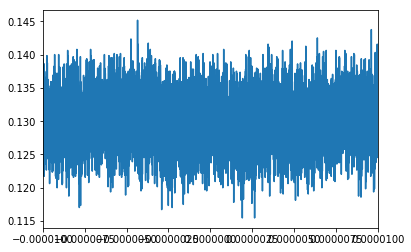

In [238]:
chan = 1

a = scope.driver.acquire([chan], timeout=None)[0].getData()
scope.driver.acquire([chan], timeout=None)[0].simplePlot()
b = np.asarray(a)
import json
file = open('/Users/lucas/Desktop/trash.json', 'a')
json.dump(b.tolist(), file)



In [64]:
a = data_ch3[0]
b = a[0: 9855]

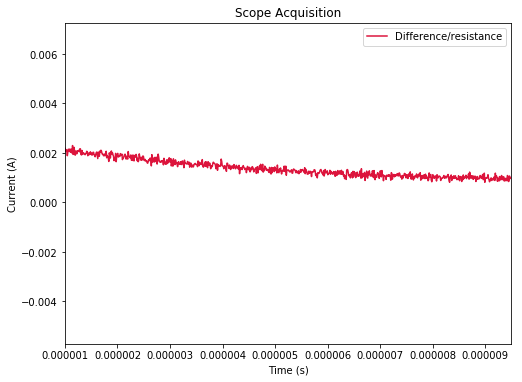

In [78]:
fig1 = plt.figure(figsize=(8,13))
ax2 = fig1.add_subplot(211)


ax2.set_title("Scope Acquisition")    
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current (A)')


ax2.set_xlim(0.000001, 0.0000095)
ax2.plot(data_ch1[0], [(i - j - 2.02)/3800 for i, j in zip(data_ch1[1], data_ch2[1])], color='crimson', label = 'Difference/resistance')

plt.legend(loc ='upper right')

for i in [0.000001, 0.0000095]:
    np.min( [(i - j - 2.02)/3800 for i, j in zip(data_ch1[1], data_ch2[1])])

In [155]:
list = []
for i in np.arange(5100,5900,10):
    list.append(data_ch1[1][i])

In [157]:
np.mean(list)
np.std(list)

0.3201464508627262

In [152]:
data_ch2[1][6400]

2.84

In [28]:
a =[(i - j)/3800 for i, j in zip(data_ch1[1], data_ch2[1])]

In [20]:
len(a)

10000

In [115]:
np.max(data_ch3[1])

0.466

In [113]:
a =[(i - j)/3800 for i, j in zip(data_ch1[1], data_ch2[1])]
a[4000]

0.023254851973684213